<a href="https://colab.research.google.com/github/veillette/jupyterNotebooks/blob/main/Classical%20Mechanics/Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classical Mechanics: Integration Techniques

### Learning Objectives:
After completing this notebook, students will be able to:
- Use numerical integration to calculate work and energy

### Prerequisites:
- Basic Python programming (variables, functions, loops)
- Introductory classical mechanics (Newton's laws, energy, oscillations)
- Calculus (derivatives, integrals)



In [ ]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import fsolve
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters for publication-quality figures
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['grid.alpha'] = 0.3


# SECTION : NUMERICAL INTEGRATION


MOTIVATION FROM PHYSICS:
Integration appears everywhere in physics: calculating work done by variable forces,
finding energy from power, determining center of mass, and analyzing experimental
data. When analytical integration is impossible or when working with discrete data,
numerical integration becomes essential.

KEY CONCEPTS:
- Trapezoidal rule for smooth functions
- Handling experimental data with uneven spacing
- Accuracy considerations and convergence
- Applications to work, energy, and experimental analysis



--- Demonstration: Trapezoidal Rule Accuracy ---
Analytical integral of sin(x) from 0 to π: 2.000000
n =   5: Numerical = 1.896119, Error = 1.04e-01
n =  11: Numerical = 1.983524, Error = 1.65e-02
n =  21: Numerical = 1.995886, Error = 4.11e-03
n =  51: Numerical = 1.999342, Error = 6.58e-04
n = 101: Numerical = 1.999836, Error = 1.64e-04


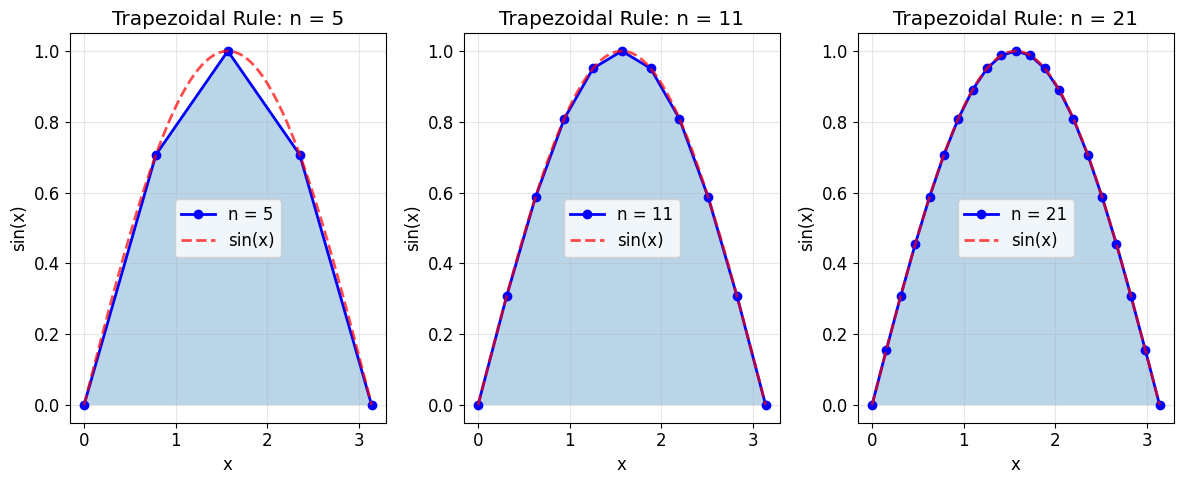

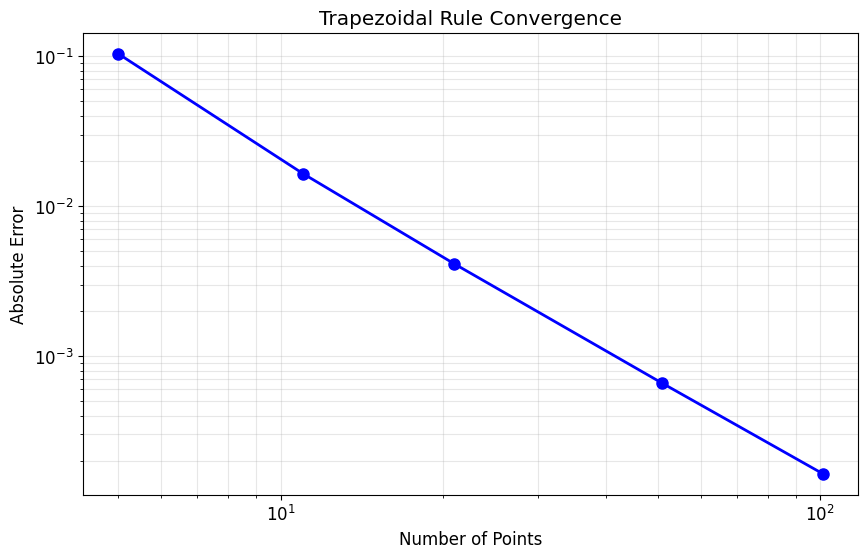

In [ ]:

def trapezoidal_rule(x, y):
    """
    Numerical integration using the trapezoidal rule.

    Parameters:
    x (array): Independent variable values (must be sorted)
    y (array): Function values at x points

    Returns:
    integral (float): Approximate integral value
    """
    # Handle non-uniform spacing
    dx = np.diff(x)
    y_avg = (y[:-1] + y[1:]) / 2.0  # Average height of each trapezoid

    # Sum of areas of all trapezoids
    integral = np.sum(dx * y_avg)

    return integral

def cumulative_integration(x, y):
    """
    Calculate cumulative integral (running sum) using trapezoidal rule.

    Returns:
    x (array): Same x values
    cum_integral (array): Cumulative integral values
    """
    cum_integral = np.zeros_like(x)

    for i in range(1, len(x)):
        # Add area of trapezoid from x[i-1] to x[i]
        dx = x[i] - x[i-1]
        area = dx * (y[i-1] + y[i]) / 2.0
        cum_integral[i] = cum_integral[i-1] + area

    return x, cum_integral

# Demonstration: Integration Accuracy
print("\n--- Demonstration: Trapezoidal Rule Accuracy ---")

# Test function with known integral: ∫sin(x)dx = -cos(x) + C
x_test = np.linspace(0, np.pi, 101)
y_test = np.sin(x_test)

# Analytical integral from 0 to π
analytical_integral = -np.cos(np.pi) + np.cos(0)  # Should be 2
print(f"Analytical integral of sin(x) from 0 to π: {analytical_integral:.6f}")

# Numerical integration with different numbers of points
n_points = [5, 11, 21, 51, 101]
errors = []

plt.figure(figsize=(12, 5))

for i, n in enumerate(n_points):
    x_n = np.linspace(0, np.pi, n)
    y_n = np.sin(x_n)

    numerical_integral = trapezoidal_rule(x_n, y_n)
    error = abs(numerical_integral - analytical_integral)
    errors.append(error)

    print(f"n = {n:3d}: Numerical = {numerical_integral:8.6f}, Error = {error:.2e}")

    # Plot for visualization
    if i < 3:  # Only plot first 3 for clarity
        plt.subplot(1, 3, i+1)
        plt.plot(x_n, y_n, 'bo-', markersize=6, label=f'n = {n}')
        plt.fill_between(x_n, 0, y_n, alpha=0.3)
        plt.plot(x_test, np.sin(x_test), 'r--', alpha=0.7, label='sin(x)')
        plt.xlabel('x')
        plt.ylabel('sin(x)')
        plt.title(f'Trapezoidal Rule: n = {n}')
        plt.legend()
        plt.grid(True)

plt.tight_layout()
plt.show()

# Convergence analysis
plt.figure(figsize=(10, 6))
plt.loglog(n_points, errors, 'bo-', markersize=8, linewidth=2)
plt.xlabel('Number of Points')
plt.ylabel('Absolute Error')
plt.title('Trapezoidal Rule Convergence')
plt.grid(True, which="both", alpha=0.3)
plt.show()




CONVERGENCE BEHAVIOR:
- Trapezoidal rule error decreases as O(h²) where h is step size
- Doubling the number of points reduces error by factor of ~4
- For smooth functions, convergence is rapid and predictable


## CHECKPOINT 1: Integration Concepts

Key questions to consider:
1. Why does the trapezoidal rule work better for smooth functions?
2. How would noise in data affect numerical integration vs differentiation?
3. What happens if the data points are not evenly spaced?



--- Physics Application 1: Work Done by Variable Force ---


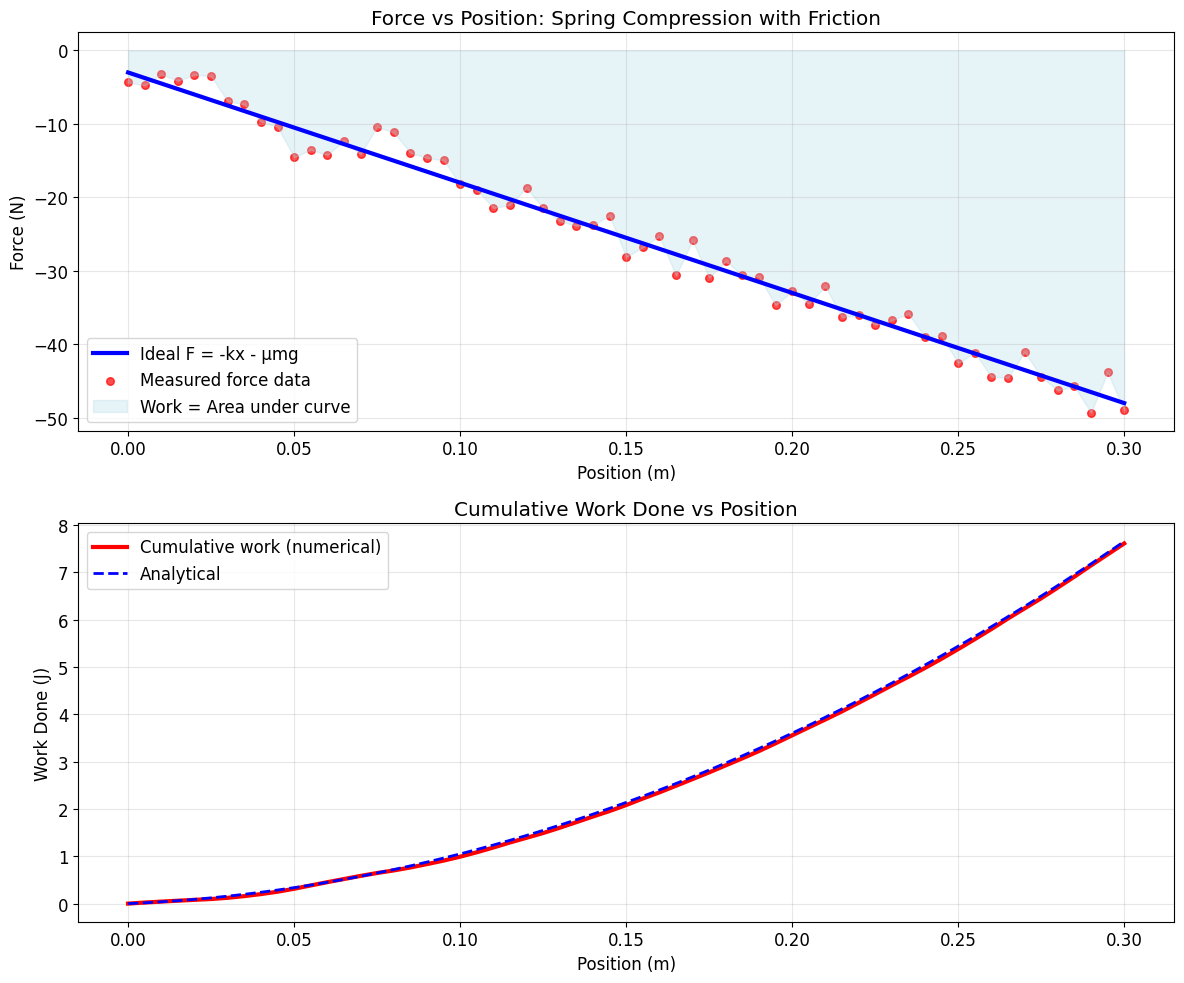

WORK CALCULATION RESULTS:
Numerical integration: 7.61 J
Analytical calculation: 7.65 J
Error: 0.04 J (0.6%)
Spring potential energy: 6.75 J
Work against friction: 0.90 J

--- Physics Application 2: Total Energy from Power vs Time ---


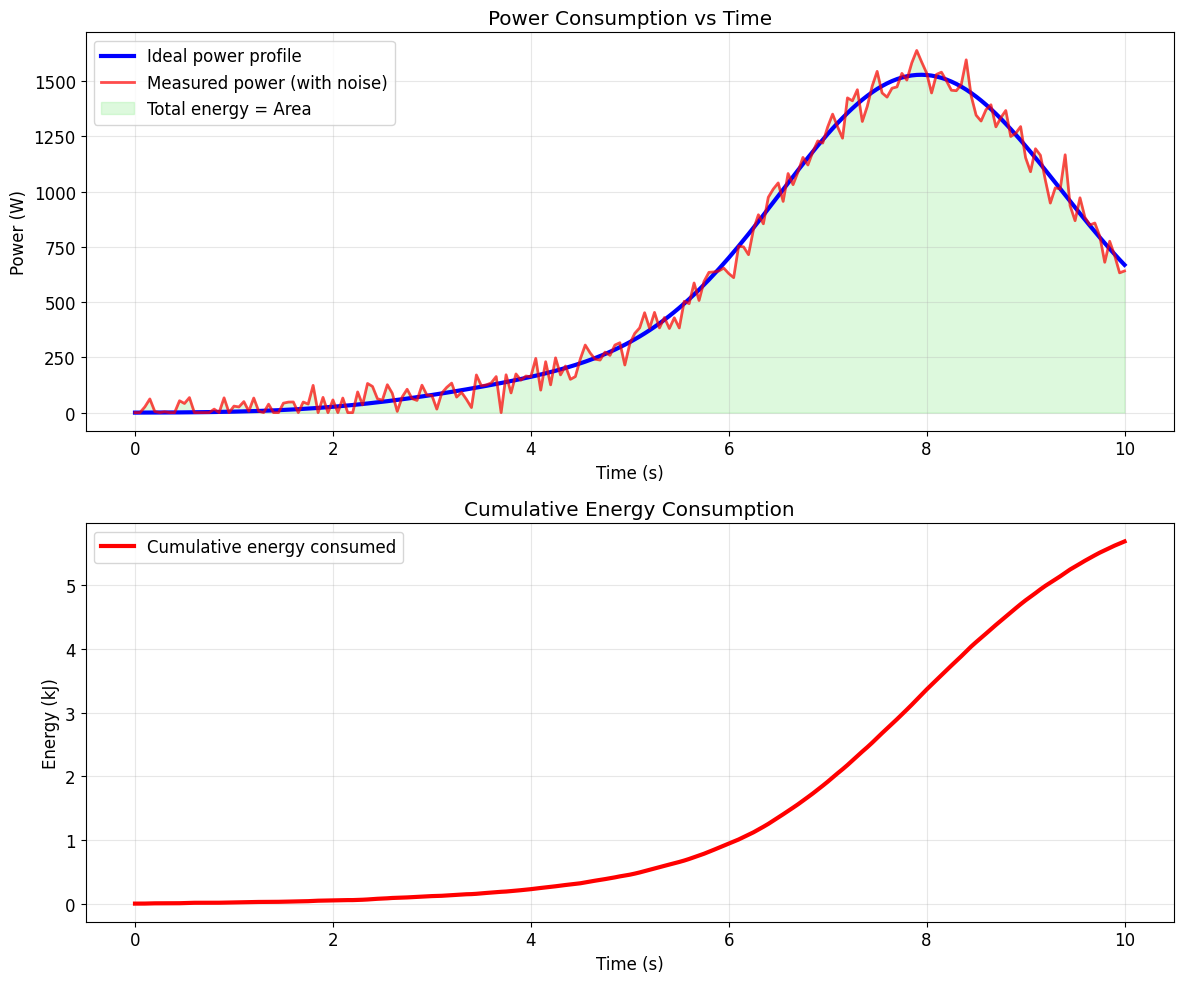

ENERGY CALCULATION RESULTS:
Total energy consumed (numerical): 5.69 kJ
Total energy consumed (ideal): 5.66 kJ
Average power: 569.1 W
Peak power: 1638.8 W


In [ ]:

# Physics Application 1: Work Done by Variable Force
print("\n--- Physics Application 1: Work Done by Variable Force ---")

# Simulate force data for a mass on a spring being compressed
# F(x) = -kx + friction force that varies with position

def spring_force_data():
    """Generate realistic force vs position data for spring compression."""
    # Parameters
    k = 150.0  # N/m spring constant
    mu_kinetic = 0.15  # kinetic friction coefficient
    mg = 20.0  # N normal force (2 kg mass)

    # Position data (compress spring from 0 to 0.3 m)
    x = np.linspace(0, 0.30, 61)  # 61 data points

    # Ideal forces
    F_spring = -k * x  # Spring restoring force
    F_friction = -mu_kinetic * mg * np.ones_like(x)  # Kinetic friction
    F_total_ideal = F_spring + F_friction

    # Add measurement noise (force sensor uncertainty)
    np.random.seed(456)
    F_measured = F_total_ideal + 2.0 * np.random.randn(len(x))  # 2N uncertainty

    return x, F_measured, F_total_ideal, k, mu_kinetic, mg

x_pos, F_meas, F_ideal, k_spring, mu, mg = spring_force_data()

# Calculate work done using numerical integration
work_numerical = -trapezoidal_rule(x_pos, F_meas)  # Negative because F opposes motion

# Analytical calculation for comparison
# W = ∫F dx = ∫(-kx - μmg) dx = -½kx² - μmg*x
x_final = x_pos[-1]
work_spring_analytical = 0.5 * k_spring * x_final**2  # Spring potential energy
work_friction_analytical = mu * mg * x_final  # Friction work
work_total_analytical = work_spring_analytical + work_friction_analytical

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Force vs position
axes[0].plot(x_pos, F_ideal, 'b-', linewidth=3, label='Ideal F = -kx - μmg')
axes[0].scatter(x_pos, F_meas, c='red', s=30, alpha=0.7, label='Measured force data')
axes[0].fill_between(x_pos, 0, F_meas, alpha=0.3, color='lightblue', label='Work = Area under curve')
axes[0].set_xlabel('Position (m)')
axes[0].set_ylabel('Force (N)')
axes[0].set_title('Force vs Position: Spring Compression with Friction')
axes[0].legend()
axes[0].grid(True)

# Cumulative work
x_cum, work_cumulative = cumulative_integration(x_pos, -F_meas)
axes[1].plot(x_cum, work_cumulative, 'r-', linewidth=3, label='Cumulative work (numerical)')

# Analytical cumulative work
work_analytical_cum = 0.5 * k_spring * x_cum**2 + mu * mg * x_cum
axes[1].plot(x_cum, work_analytical_cum, 'b--', linewidth=2, label='Analytical')
axes[1].set_xlabel('Position (m)')
axes[1].set_ylabel('Work Done (J)')
axes[1].set_title('Cumulative Work Done vs Position')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Results comparison
print("WORK CALCULATION RESULTS:")
print(f"Numerical integration: {work_numerical:.2f} J")
print(f"Analytical calculation: {work_total_analytical:.2f} J")
print(f"Error: {abs(work_numerical - work_total_analytical):.2f} J ({abs(work_numerical - work_total_analytical)/work_total_analytical*100:.1f}%)")
print(f"Spring potential energy: {work_spring_analytical:.2f} J")
print(f"Work against friction: {work_friction_analytical:.2f} J")

# Physics Application 2: Energy from Power Data
print("\n--- Physics Application 2: Total Energy from Power vs Time ---")

def power_data():
    """Generate realistic power vs time data for energy calculation."""
    # Simulate power consumption of a variable-load motor
    t = np.linspace(0, 10, 201)  # 10 seconds, 201 points

    # Power profile: startup, steady state, variable load, shutdown
    P_base = 1200  # Watts base power
    P_ideal = P_base * (1 - np.exp(-t/2)) * (1 + 0.3*np.sin(t)) * np.exp(-0.1*(t-8)**2)

    # Add measurement noise (power meter uncertainty)
    np.random.seed(789)
    P_measured = P_ideal + 50 * np.random.randn(len(t))  # 50W uncertainty
    P_measured = np.maximum(P_measured, 0)  # Power cannot be negative

    return t, P_measured, P_ideal

t_power, P_meas, P_ideal = power_data()

# Calculate total energy consumed
energy_numerical = trapezoidal_rule(t_power, P_meas)  # Energy = ∫P dt
energy_ideal = trapezoidal_rule(t_power, P_ideal)

# Calculate instantaneous energy consumption
t_energy, energy_cumulative = cumulative_integration(t_power, P_meas)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Power vs time
axes[0].plot(t_power, P_ideal, 'b-', linewidth=3, label='Ideal power profile')
axes[0].plot(t_power, P_meas, 'r-', alpha=0.7, label='Measured power (with noise)')
axes[0].fill_between(t_power, 0, P_meas, alpha=0.3, color='lightgreen', label='Total energy = Area')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Power (W)')
axes[0].set_title('Power Consumption vs Time')
axes[0].legend()
axes[0].grid(True)

# Cumulative energy
axes[1].plot(t_energy, energy_cumulative/1000, 'r-', linewidth=3, label='Cumulative energy consumed')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Energy (kJ)')
axes[1].set_title('Cumulative Energy Consumption')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("ENERGY CALCULATION RESULTS:")
print(f"Total energy consumed (numerical): {energy_numerical/1000:.2f} kJ")
print(f"Total energy consumed (ideal): {energy_ideal/1000:.2f} kJ")
print(f"Average power: {energy_numerical/t_power[-1]:.1f} W")
print(f"Peak power: {np.max(P_meas):.1f} W")
